In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, text

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [21]:
# explore and understand the data

# Create the inspector and connect it to the engine
inspector = inspect(engine)

# Collect the names of tables within the database
tables = inspector.get_table_names()

# Using the inspector to print the column names within each table and its types
for table in tables:
    print(table)
    columns = inspector.get_columns(table)
    for column in columns:
        print(column["name"], column["type"])
        
    print()

measurement
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

station
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT



In [22]:
inspector = inspect(engine)
columns = inspector.get_columns('dow')
for c in columns:
    print(c['name'], c["type"])

In [23]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [24]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [25]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [26]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [27]:
# Find the most recent date in the data set.
query = "SELECT max(date) from measurement;"

data = engine.execute(text(query)).all()
data

[('2017-08-23',)]

In [28]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date
# Calculate the date one year from the last date in data set.


# Perform a query to retrieve the data and precipitation scores


# Save the query results as a Pandas DataFrame. Explicitly set the column names


# Sort the dataframe by date





('2017-08-23',)

In [29]:
# Calculate the date one year from the last date in data set.
one_year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
one_year_ago

datetime.date(2016, 8, 23)

In [30]:
prcp_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

In [31]:
# Perform a query to retrieve the data and precipitation scores
query = """SELECT
                date,
                station,
                prcp
            FROM
                measurement
            WHERE
                date >= '2016-08-23';
"""


In [32]:
# Save the Query Results as a Pandas DataFrame and Set the Index to the Date Column & Sort the Dataframe Values by `date`
df = pd.read_sql(text(query), con=engine)
df.head()

,date,station,prcp
0,2016-08-23,USC00519397,0.00
1,2016-08-24,USC00519397,0.08
2,2016-08-25,USC00519397,0.08
3,2016-08-26,USC00519397,0.00
4,2016-08-27,USC00519397,0.00


In [33]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
data = session.query(Measurement.date, Measurement.station, Measurement.prcp).where(Measurement.date >= '2016-08-23').all()
df2 = pd.DataFrame(data, columns=["DATE", "STATION", "PRCP"])

df2.head()

,DATE,STATION,PRCP
0,2016-08-23,USC00519397,0.00
1,2016-08-24,USC00519397,0.08
2,2016-08-25,USC00519397,0.08
3,2016-08-26,USC00519397,0.00
4,2016-08-27,USC00519397,0.00


In [40]:
df2 = df2.sort_values(by='DATE')

df2.head()

,DATE,STATION,PRCP
0,2016-08-23,USC00519397,0.00
1009,2016-08-23,USC00517948,NaN
1529,2016-08-23,USC00519281,1.79
704,2016-08-23,USC00514830,0.05
361,2016-08-23,USC00513117,0.15


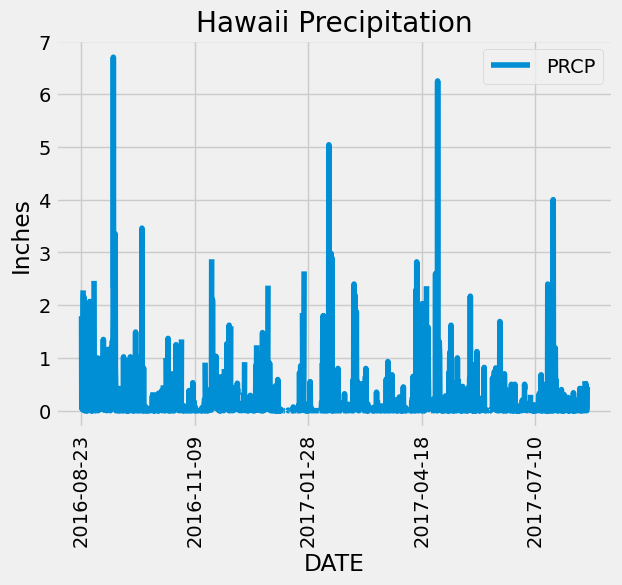

In [42]:
# Use Pandas Plotting with Matplotlib to plot the data
df2.plot(kind="line", x="DATE", y="PRCP", title="Hawaii Precipitation", ylabel="Inches", rot=90)
plt.show()

In [43]:
# Use Pandas to calculate the summary statistics for the precipitation data
df2.describe()

,PRCP
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [44]:
# Design a query to calculate the total number of stations in the dataset
query = "SELECT count(id) from station;"

data = engine.execute(text(query)).all()
data

[(9,)]

In [45]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [46]:
query = """SELECT
                station,
                count(id) as num_obs
            FROM
                measurement
            GROUP BY
                station
            ORDER BY
                num_obs desc;
"""

df2 = pd.read_sql(text(query), con=engine)
df2.head(10)

,station,num_obs
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [47]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]

min_max_avg_temp = session.query(*sel).\
    filter(Measurement.station == "USC00519281").all()
min_max_avg_temp

[(54.0, 85.0, 71.66378066378067)]

In [48]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs = session.query(Measurement.date, Measurement.station, Measurement.tobs).filter(Measurement.date >= '2016-08-23').filter(Measurement.station == 'USC00519281').order_by(Measurement.date).all()

df2 = pd.DataFrame(tobs, columns=["Date", "Station", "Tobs"])

df2.head()



,Date,Station,Tobs
0,2016-08-23,USC00519281,77.0
1,2016-08-24,USC00519281,77.0
2,2016-08-25,USC00519281,80.0
3,2016-08-26,USC00519281,80.0
4,2016-08-27,USC00519281,75.0


Text(0.5, 4.183333333333314, 'Temperature')

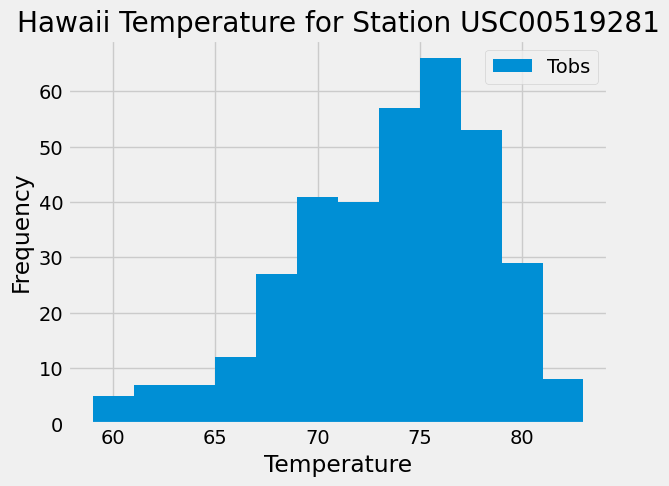

In [50]:
# Plot the Results as a Histogram with `bins=12`
df2.plot.hist(bins=12, title="Hawaii Temperature for Station USC00519281", ylabel="Frequency")
plt.tight_layout()
plt.xlabel("Temperature")

# Close Session

In [51]:
# Close Session
session.close()